In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
# from data_loading import read_hackathon_data
from dataset.june_dataset import JuNEDataset

from metrics.metrics_time import TimeMetrics
from itertools import product
import matplotlib.pyplot as plt
import pingouin as pg

df = pd.read_csv('../data/all_data_06_09_2023.csv', index_col=0)
june = JuNEDataset(df)
june.prepare_dataset()
df = june.df

In [2]:
cell_labels = pd.read_csv('../data/action_id_label_mapping.csv', index_col=0)

In [3]:
df = df.merge(cell_labels, on = 'action_id', suffixes=['','_correct'])

In [4]:
TM = TimeMetrics()
metrics = TM.calculate_metrics(df)
metrics.head()
kernel_mapping  = metrics.loc[:, ['kernel_id', 'task', 'expert']].drop_duplicates()

# Action time

In [6]:
metrics.groupby(['task', 'expert']).next_action_time.describe()

count       mean         std    min      25%    50%       75%  \
task  expert                                                                   
task1 False   5718.0  42.983284  309.940488  0.000  1.46950  7.725  26.78825   
      True    1548.0  31.697414   73.155112  0.000  2.48525  9.797  33.18100   
task2 False   1717.0  42.879314  323.199584  0.001  1.65900  5.711  19.66900   
      True    2853.0  27.812308  155.382600  0.000  0.74900  3.917  14.14500   

                    max  
task  expert             
task1 False   12649.736  
      True     1426.984  
task2 False    9607.840  
      True     4114.957

In [7]:
test  = metrics.groupby(['task', 'expert']).describe()

In [8]:
tr = metrics.next_action_time.quantile(.95)
# TODO recalculate execute time
at_df = metrics.loc[(metrics.next_action_time < tr), :]

In [40]:
cols = list(product(['execution_time_sec', 'next_action_time'],['mean', 'std']))
desc_stats_all = at_df.groupby(['task', 'expert']).describe().loc[:,cols]
desc_stats_exp = at_df.groupby(['expert']).describe().loc[:,cols]
desc_stats_task = at_df.groupby(['task']).describe().loc[:,cols]

In [12]:
pg.anova(data=at_df, dv= 'next_action_time', between=['task', 'expert'])

,Source,SS,DF,MS,F,p-unc,np2
0,task,6.271275e+04,1.0,62712.750493,118.240495,2.102488e-27,0.010410
1,expert,3.125230e+02,1.0,312.522966,0.589240,4.427292e-01,0.000052
2,task * expert,1.682978e+04,1.0,16829.775497,31.731362,1.812942e-08,0.002815
3,Residual,5.961505e+06,11240.0,530.383015,NaN,NaN,NaN


In [13]:

sns.set(rc={'figure.figsize':(13.7,6.27)})
def plot_box_time(df, var='next_action_time'):

    df = df[df.cell_label_correct.apply(lambda x: len(x.strip().split(',')) - 1 if isinstance(x, str) else None) == 1]
    my_order = df.groupby(by=["cell_label_correct"])[var].mean()
    my_order = my_order.sort_values().index

    sns.boxplot(df, x='cell_label_correct', y =var, order=my_order)

    plt.xticks(rotation=90)


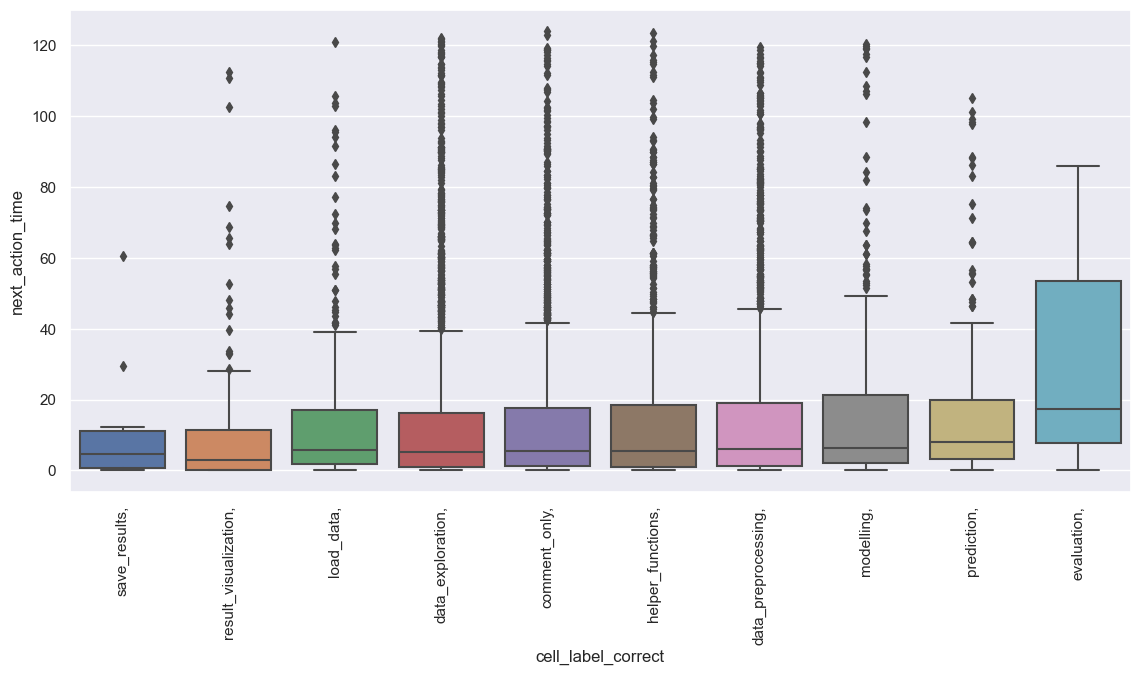

In [14]:
plot_box_time(at_df)

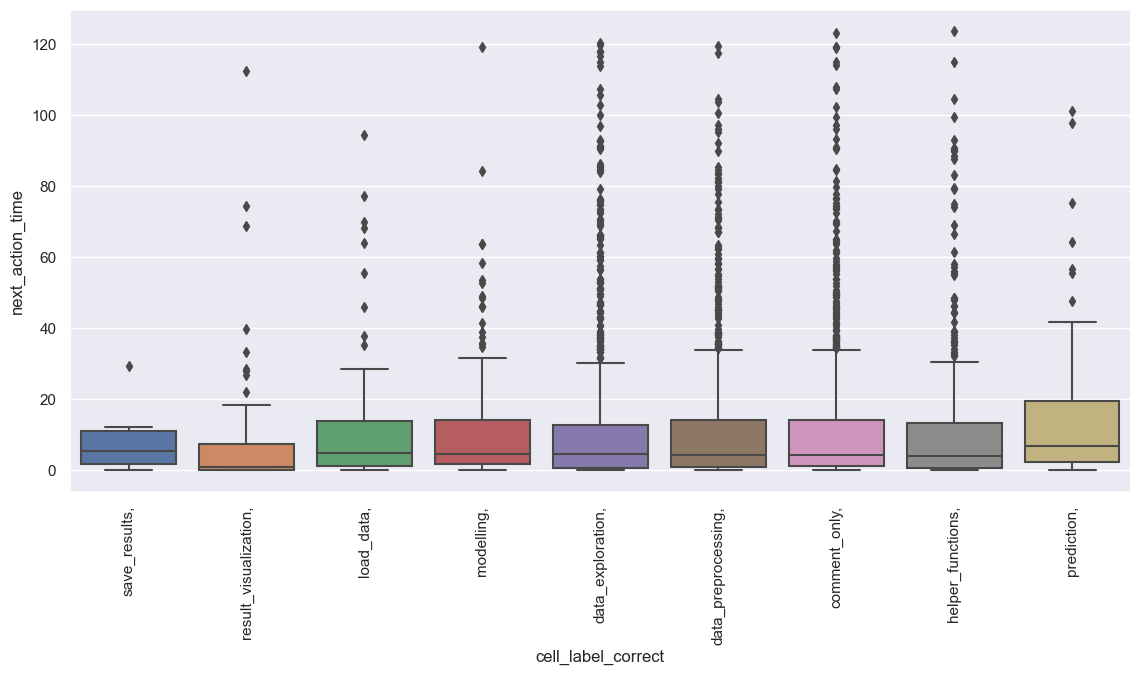

In [15]:
plot_box_time(at_df[at_df.task == 'task2'])

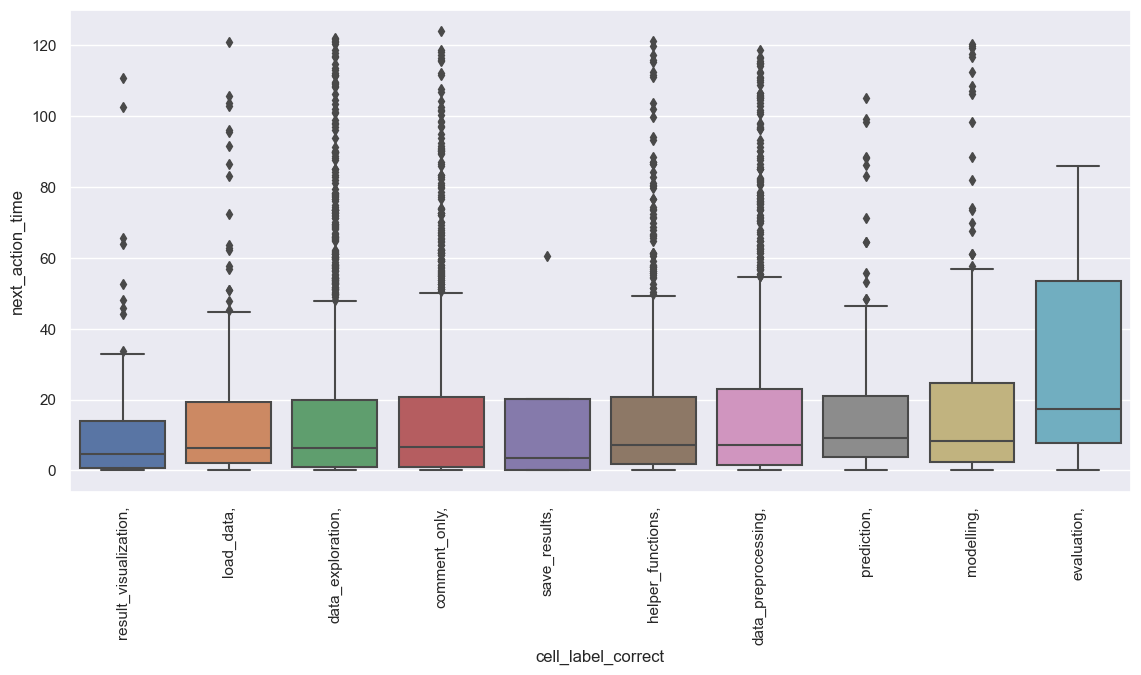

In [16]:
plot_box_time(at_df[at_df.task == 'task1'])

# Execution time

In [17]:
# TODO:
# deal with missing execs
# metrics.loc[metrics.event == 'execute', ['kernel_id','expert','task', 'state_time_dt']].state_time_dt.isna().sum()

In [18]:
metrics.loc[metrics.event == 'execute', 'cell_index'].nunique(), len(metrics[metrics.event == 'execute'])

(1963, 9207)

In [126]:
sum_exec = metrics.groupby('kernel_id').apply(lambda x: x.loc[x.event == 'execute', 'execution_time_sec'].sum()).to_frame('exec_time_sum') / 60
sum_exec_count = metrics.groupby('kernel_id').apply(lambda x: x.loc[x.event == 'execute', 'execution_time_sec'].count()).to_frame('exec_time_count')
sum_exec_mean = metrics.groupby('kernel_id').apply(lambda x: x.loc[x.event == 'execute', 'execution_time_sec'].mean()).to_frame('exec_time_mean') / 60
sum_all = metrics.groupby('kernel_id').next_action_time.sum().to_frame('overall_time') / 60

kernel_time_df = kernel_mapping.merge(sum_exec, on = 'kernel_id').merge(sum_exec_mean, on = 'kernel_id').merge(sum_all, on = 'kernel_id').merge(sum_exec_count, on = 'kernel_id')
kernel_time_df['percent'] = kernel_time_df.exec_time_sum / kernel_time_df.overall_time * 100
kernel_time_df['exec_time_n'] = kernel_time_df.exec_time_sum / kernel_time_df.exec_time_count
exec_comp = kernel_time_df.groupby(['task', 'expert']).describe()
exec_comp_task = kernel_time_df.groupby('task').describe()
exec_comp_exp = kernel_time_df.groupby('expert').describe()

cols = list(product(['exec_time_sum', 'percent','exec_time_n'],['mean', 'std']))
exec_stats = exec_comp.loc[:,cols]
exec_stats


exec_time_sum               percent            exec_time_n  \
                      mean        std       mean        std        mean   
task  expert                                                              
task1 False      15.491702  13.892578   7.604895   8.479777    0.046091   
      True        4.852870   4.124956   2.939032   2.575988    0.021221   
task2 False      28.608836  27.395937  11.896294   9.504634    0.124502   
      True       30.828633  38.964322  14.205822  13.352789    0.089659   

                        
                   std  
task  expert            
task1 False   0.024745  
      True    0.020112  
task2 False   0.077949  
      True    0.100282

In [138]:
test2

task expert exec_time_sum                                            \
                        count       mean        std       min       25%   
0  task1  False          14.0  15.491702  13.892578  2.239617  6.112413   
1  task1   True           5.0   4.852870   4.124956  0.632100  1.903200   
2  task2  False           6.0  28.608836  27.395937  2.866833  6.664854   
3  task2   True           6.0  30.828633  38.964322  2.394583  5.188154   
0  task1    NaN          19.0  12.692010  12.897256  0.632100  4.572092   
1  task2    NaN          12.0  29.718735  32.134039  2.394583  4.001883   
0    NaN  False          20.0  19.426842  19.172875  2.239617  5.900800   
1    NaN   True          11.0  19.021468  30.821022  0.632100  2.822083   

                                     ...    percent            exec_time_n  \
         50%        75%         max  ...        75%        max       count   
0   9.161258  23.227525   47.712133  ...   8.254404  33.257847        14.0   
1   3.249583   8.746817    9.732650  ...   5.347142   6.092720         5.0   
2  21.286375  45.709346   70.572083  ...  17.895079  26.457222         6.0   
3  15.324350  38.642433  103.703967  ...  21.834732  35.152719         6.0   
0   8.735633  14.774992   47.712133  ...   7.101501  33.257847        19.0   
1  17.309650  46.399567  103.703967  ...  21.142034  35.152719        12.0   
0  11.089933  27.893558   70.572083  ...   9.275060  33.257847        20.0   
1   8.746817  15.324350  103.703967  ...  11.058025  35.152719        11.0   

                                                                         
       mean       std       min       25%       50%       75%       max  
0  0.046091  0.024745  0.013262  0.030326  0.047602  0.056856  0.098792  
1  0.021221  0.020112  0.003129  0.008852  0.010760  0.031910  0.051452  
2  0.124502  0.077949  0.012856  0.068333  0.149448  0.176551  0.208378  
3  0.089659  0.100282  0.006670  0.024219  0.063466  0.101697  0.278774  
0  0.039546  0.025666  0.003129  0.016606  0.031995  0.055958  0.098792  
1  0.107080  0.087545  0.006670  0.038504  0.094893  0.175018  0.278774  
0  0.069614  0.058112  0.012856  0.030683  0.053780  0.081319  0.208378  
1  0.058551  0.080420  0.003129  0.009806  0.031910  0.066368  0.278774  

[8 rows x 50 columns]

In [140]:
test

Execution time (sec)        Time between actions (sec)  \
                                  mean    std                       mean   
Task Expert                                                                
DS   Student                      2,66  14,14                      17,16   
     Professional                 1,23   9,41                      19,40   
     All                          2,36  13,29                      17,64   
ML   Student                      5,22  39,45                      14,24   
     Professional                 3,34  32,18                      10,91   
     All                          4,08  35,24                      12,15   
All  Student                      3,26  22,76                      16,48   
     Professional                 2,57  26,26                      13,86   

                         % of total time         
                     std            mean    std  
Task Expert                                      
DS   Student       24,77            7,60   8,48  
     Professional  25,28            2,94   2,58  
     All           24,90            6,38   7,61  
ML   Student       22,22           11,90   9,50  
     Professional  18,18           14,21  13,35  
     All           19,84           13,05  11,12  
All  Student       24,24            8,89   8,78  
     Professional  21,31            9,08  11,24

In [139]:
# TODO: Refactor normal names
test = pd.concat([desc_stats_all.reset_index(), desc_stats_task.reset_index(), desc_stats_exp.reset_index()])
test2 = pd.concat([exec_comp.reset_index(), exec_comp_task.reset_index(), exec_comp_exp.reset_index()])
test = pd.concat([test, test2[[('percent', 'mean'), ('percent', 'std')]]], axis=1)

pretty_lang = {'task1': 'DS', 'task2': 'ML', np.NaN: 'All',
               False: 'Student', True: 'Professional'}
new_names = ['Task','Expert', 'Execution time (sec)', 'Execution time (sec)', 'Time between actions (sec)', 'Time between actions (sec)', '% of total time', '% of total time']
test.columns =  pd.MultiIndex.from_tuples([(new_names[i] ,column[1]) for i, column in enumerate(test.columns.to_list())])
test = test.replace(pretty_lang).set_index(['Task', 'Expert']).applymap(lambda x: str.format("{:0_.2f}", x).replace('.', ',').replace('_', '.'))
test = test.loc[test.index[[0,1,4,2,3,5,6,7]]]
print(test.to_latex(escape=True))

\begin{tabular}{llllllll}
\toprule
 &  & \multicolumn{2}{r}{Execution time (sec)} & \multicolumn{2}{r}{Time between actions (sec)} & \multicolumn{2}{r}{\% of total time} \\
 &  & mean & std & mean & std & mean & std \\
Task & Expert &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{DS} & Student & 2,66 & 14,14 & 17,16 & 24,77 & 7,60 & 8,48 \\
 & Professional & 1,23 & 9,41 & 19,40 & 25,28 & 2,94 & 2,58 \\
 & All & 2,36 & 13,29 & 17,64 & 24,90 & 6,38 & 7,61 \\
\cline{1-8}
\multirow[t]{3}{*}{ML} & Student & 5,22 & 39,45 & 14,24 & 22,22 & 11,90 & 9,50 \\
 & Professional & 3,34 & 32,18 & 10,91 & 18,18 & 14,21 & 13,35 \\
 & All & 4,08 & 35,24 & 12,15 & 19,84 & 13,05 & 11,12 \\
\cline{1-8}
\multirow[t]{2}{*}{All} & Student & 3,26 & 22,76 & 16,48 & 24,24 & 8,89 & 8,78 \\
 & Professional & 2,57 & 26,26 & 13,86 & 21,31 & 9,08 & 11,24 \\
\cline{1-8}
\bottomrule
\end{tabular}


In [26]:
execs = metrics.loc[metrics.event == 'execute', ['kernel_id','expert','task', 'execution_time_sec']].dropna()

8.960528751570745

In [21]:
execs.anova(dv="execution_time_sec", between=["expert", "task"]).round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,expert,6539.547,1.0,6539.547,6.476,0.011,0.001
1,task,36139.237,1.0,36139.237,35.787,0.000,0.004
2,expert * task,80.944,1.0,80.944,0.080,0.777,0.000
3,Residual,9063344.666,8975.0,1009.843,NaN,NaN,NaN


In [22]:
t1_execs_s = kernel_time_df.loc[((~kernel_time_df.expert) & (kernel_time_df.task == 'task1')), 'exec_time_count']
t1_execs_e = kernel_time_df.loc[((kernel_time_df.expert) & (kernel_time_df.task == 'task1')), 'exec_time_count']
pg.ttest(t1_execs_s, t1_execs_e).round(2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.46,16.83,two-sided,0.16,"[-33.81, 185.78]",0.51,0.868,0.15


In [23]:
t1_execs_s = kernel_time_df.loc[((~kernel_time_df.expert) & (kernel_time_df.task == 'task1')), 'exec_time_n']
t1_execs_e = kernel_time_df.loc[((kernel_time_df.expert) & (kernel_time_df.task == 'task1')), 'exec_time_n']
pg.ttest(t1_execs_s, t1_execs_e).round(2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.23,8.71,two-sided,0.05,"[-0.0, 0.05]",1.05,1.996,0.48


In [167]:
t1_execs_s = kernel_time_df.loc[((~kernel_time_df.expert) & (kernel_time_df.task == 'task2')), 'exec_time_n']
t1_execs_e = kernel_time_df.loc[((kernel_time_df.expert) & (kernel_time_df.task == 'task2')), 'exec_time_n']
pg.ttest(t1_execs_s, t1_execs_e).round(2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.67,10,two-sided,0.52,"[-0.08, 0.15]",0.39,0.54,0.09


task expert execution_time_sec            next_action_time           
                              mean        std             mean        std
0  task1  False           2.663497  14.144159        17.159251  24.772406
1  task1   True           1.233623   9.411577        19.400339  25.276829
2  task2  False           5.216494  39.453154        14.242719  22.224630
3  task2   True           3.340555  32.178577        10.910147  18.182537

In [28]:
pd.concat([desc_stats, exec_stats['percent']], axis=1)

              (execution_time_sec, mean)  (execution_time_sec, std)  \
task  expert                                                          
task1 False                     2.663497                  14.144159   
      True                      1.233623                   9.411577   
task2 False                     5.216494                  39.453154   
      True                      3.340555                  32.178577   

              (next_action_time, mean)  (next_action_time, std)       mean  \
task  expert                                                                 
task1 False                  17.159251                24.772406   7.604895   
      True                   19.400339                25.276829   2.939032   
task2 False                  14.242719                22.224630  11.896294   
      True                   10.910147                18.182537  14.205822   

                    std  
task  expert             
task1 False    8.479777  
      True     2.575988  


In [37]:
for column in exec_stats['percent'].columns:
    desc_stats[('percent',column)] = exec_stats[('percent', column)]

In [38]:
desc_stats

execution_time_sec            next_action_time             \
                           mean        std             mean        std   
task  expert                                                             
task1 False            2.663497  14.144159        17.159251  24.772406   
      True             1.233623   9.411577        19.400339  25.276829   
task2 False            5.216494  39.453154        14.242719  22.224630   
      True             3.340555  32.178577        10.910147  18.182537   

                percent             
                   mean        std  
task  expert                        
task1 False    7.604895   8.479777  
      True     2.939032   2.575988  
task2 False   11.896294   9.504634  
      True    14.205822  13.352789

In [32]:
pd.merge(desc_stats.reset_index(), exec_stats['percent'].reset_index(), on = ['task', 'expert'])

MergeError: Not allowed to merge between different levels. (2 levels on the left, 1 on the right)

In [168]:
# TODO: check difference in exec time 
metrics.groupby('labels').execution_time_sec.describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
"evaluation,",16.0,0.075000,0.080208,0.001,0.02300,0.0435,0.12900,0.299
"helper_functions,evaluation,",37.0,0.125865,0.062612,0.002,0.10400,0.1520,0.16100,0.245
"result_visualization,",12.0,0.142000,0.139930,0.003,0.06625,0.0815,0.15650,0.467
"helper_functions,data_exploration,",9.0,0.432889,0.206776,0.045,0.33800,0.4720,0.49300,0.827
"prediction,",194.0,0.540155,2.737858,0.004,0.05700,0.1240,0.18875,26.227
"load_data,data_exploration,",15.0,0.599867,0.256084,0.001,0.53450,0.7390,0.76200,0.774
"load_data,",220.0,0.643182,1.870342,0.000,0.04175,0.1620,0.63525,18.155
"comment_only,",1051.0,0.706887,6.704457,0.000,0.03200,0.0470,0.10450,139.579
"data_exploration,modelling,",4.0,0.907250,0.603882,0.555,0.55950,0.6335,0.98125,1.807


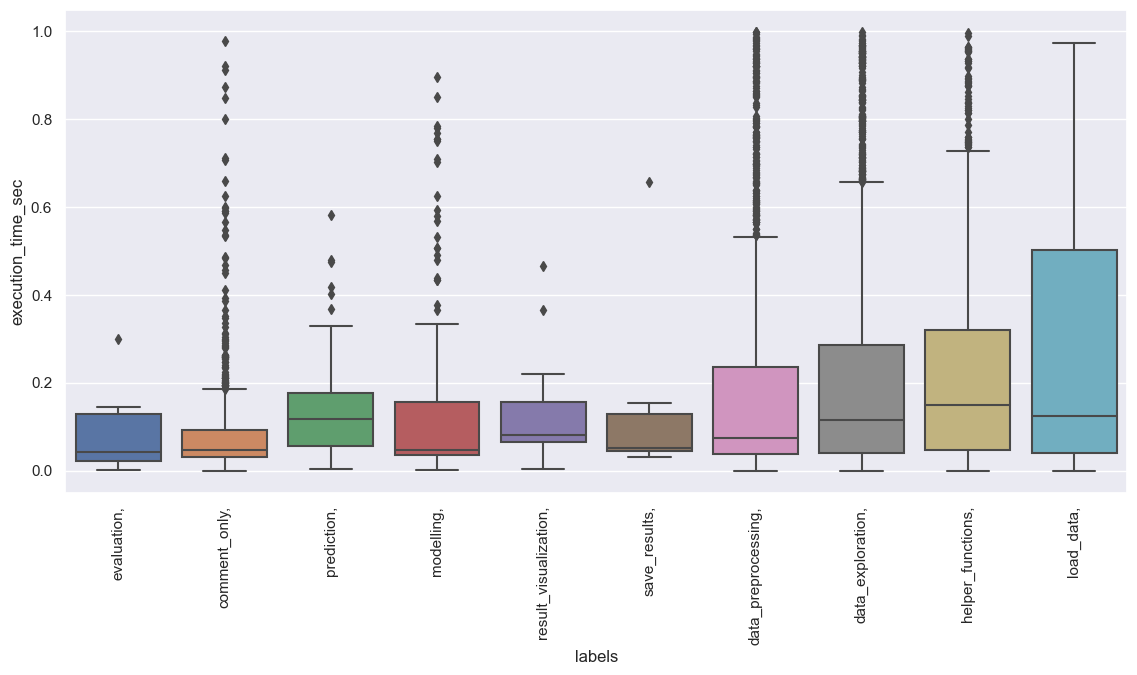

In [169]:
plot_box_time(metrics[metrics.execution_time_sec < 1], var='execution_time_sec')

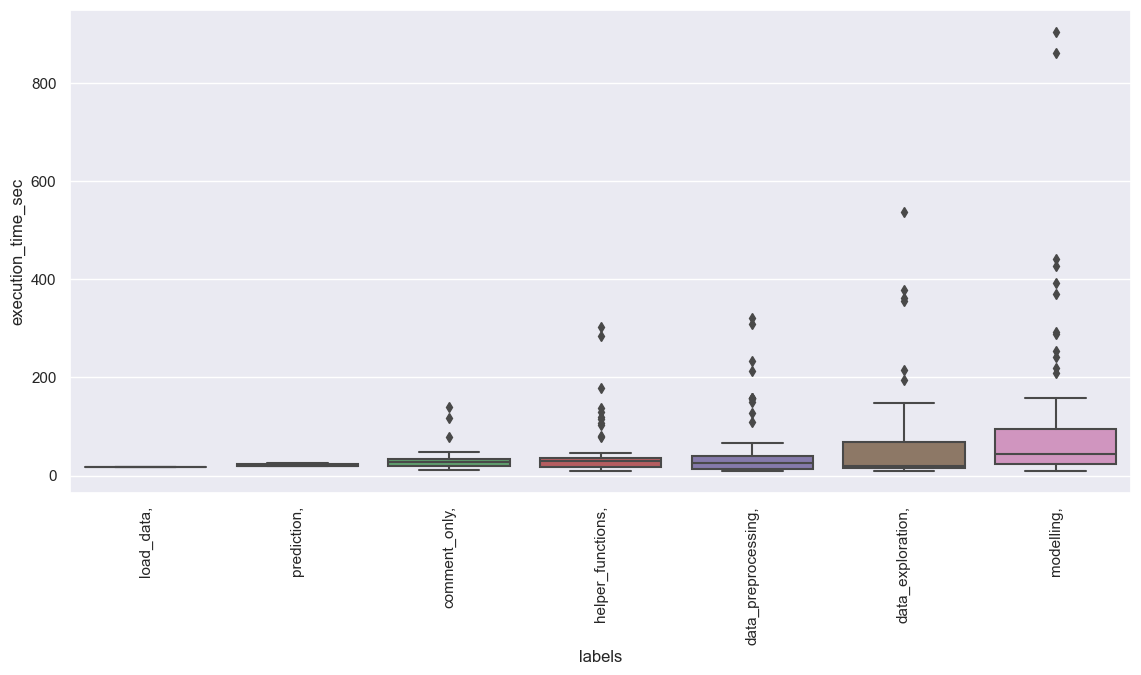

In [170]:
plot_box_time(metrics[metrics.execution_time_sec > 10], var='execution_time_sec')

In [171]:
metrics['scr_len'] = metrics.cell_source.str.len()

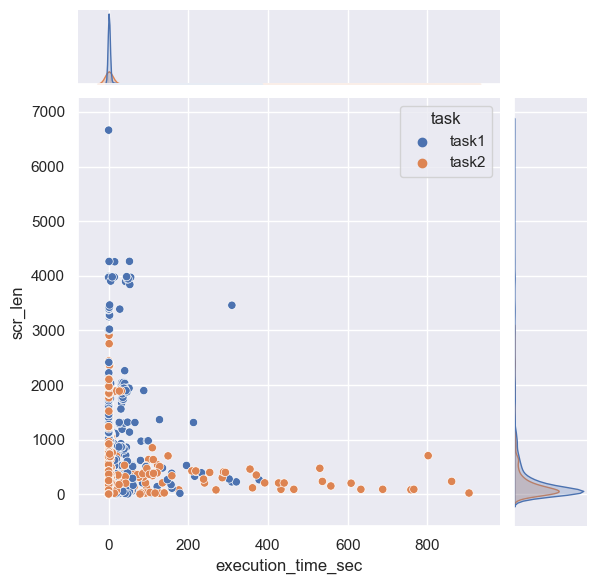

In [172]:
sns.jointplot(metrics[metrics.event == 'execute'], x='execution_time_sec', y='scr_len', hue='task');

In [173]:
pg.corr(metrics[metrics.event == 'execute'].execution_time_sec, metrics[metrics.event == 'execute'].scr_len)

,n,r,CI95%,p-val,BF10,power
pearson,8978,0.058308,"[0.04, 0.08]",3.224671e-08,5.728e+04,0.999822


In [94]:
# plot_box_time(metrics[metrics.execution_time_sec < 10], var='execution_time_sec')

# Interruptions

In [ ]:
metrics

In [111]:
test = metrics[metrics.labels.apply(lambda x: len(x.strip().split(',')) - 1 if isinstance(x, str) else None) == 1]

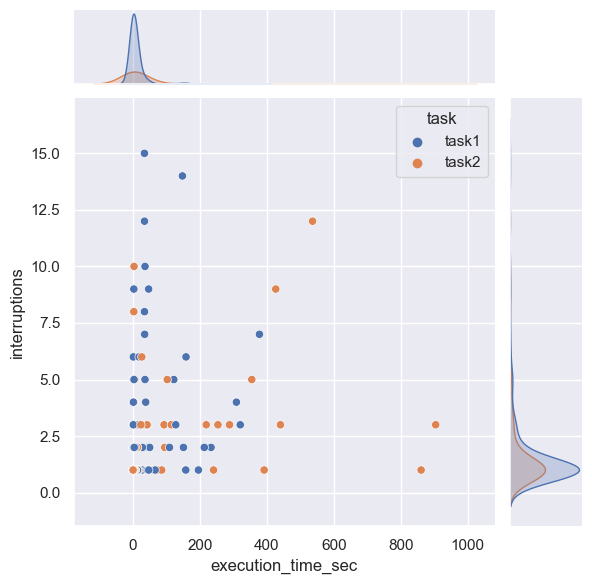

In [145]:
sns.jointplot(test[(test.labels != 'helper_functions,')& (test.interruptions > 0)], x='execution_time_sec', y='interruptions', hue='task');

<Axes: xlabel='labels', ylabel='interruptions'>

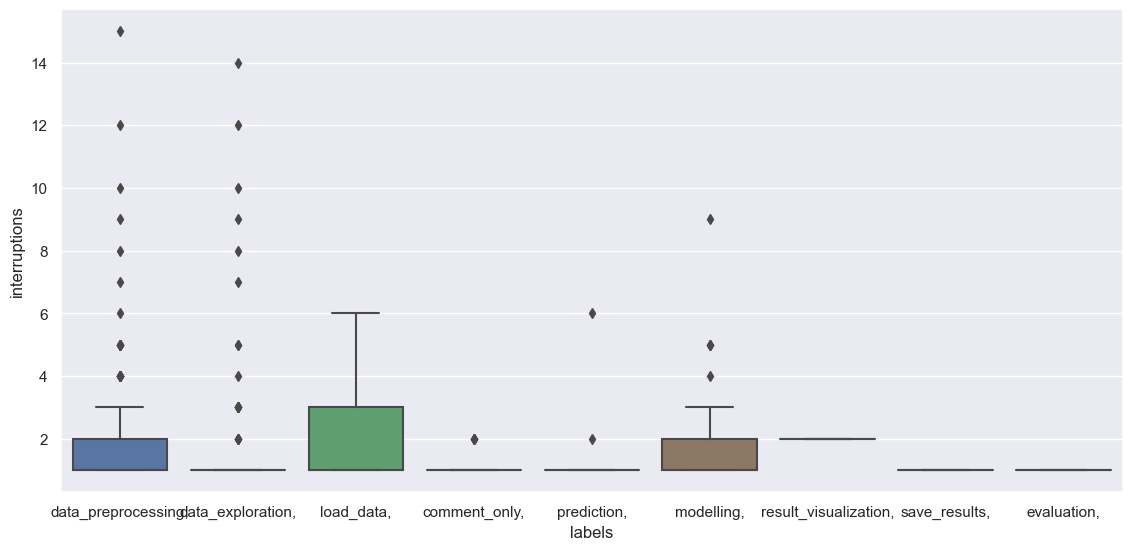

In [174]:
test_plot = test[(test.interruptions > 0)]
sns.boxplot(test[(test.labels != 'helper_functions,')& (test.interruptions > 0)], x='labels', y='interruptions')

In [124]:
kernel_time_df

,kernel_id,task,expert,exec_time_sum,exec_time_mean,overall_time,exec_time_count,percent,exec_time_n
0,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1,False,2.400483,0.013262,144.041617,181,1.666521,0.013262
1,033a2c63-4cfb-4cc5-9988-59c48a06eb23,task1,False,6.741050,0.019096,223.492867,353,3.016226,0.019096
2,19160d7e-eb8e-4a81-9e92-e9d8335eee31,task1,True,1.903200,0.008852,151.073600,215,1.259783,0.008852
3,232bcb48-7455-4109-9eeb-809649a6bedc,task2,True,20.449583,0.045646,279.871267,448,7.306782,0.045646
4,29da7c56-5a69-485f-b181-a0a7199a559c,task1,False,37.145933,0.098792,213.735483,376,17.379395,0.098792
5,2bc4e2c9-833e-454f-8c6c-2dff1e6e60e9,task2,False,14.169717,0.208378,241.559917,68,5.865922,0.208378
6,2d945a8d-90c3-40a6-a576-f1b7cf5d6790,task1,True,9.732650,0.031910,182.015917,305,5.347142,0.031910
7,3179a989-9b41-49b9-84f8-5fe83a7c65bf,task2,True,103.703967,0.278774,295.009800,372,35.152719,0.278774
8,36c724d9-3a5f-43e2-aba2-2d0933046f35,task1,False,27.723733,0.067291,537.872283,412,5.154334,0.067291
9,388ef554-e3e7-4410-89ac-d6ad4aeaec6c,task2,False,2.866833,0.012856,134.999850,223,2.123583,0.012856
